# Flight Delay Prediction - EDA 
UC Berkeley, School of Information  
Authors: Tim Chen, Eugene Shen, Yang Jing, Pino Gei  
Notebooks: [Model (Main Notebook)](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4135716278511792/command/4135716278511793) | [EDA](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120639713/command/439895120639714) | [Data Cleaning & Join](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683) | [GBT Toy Example](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1553213441189954/command/1553213441189955)

The EDA analysis presented in this notebook is a part of the [Flight Delay Prediction](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4135716278511792/command/439895120639168) project. A total of 14 EDAs are included, all of which provide important inputs to our feature engineering/selection and model training/fine-tuning. Our EDA is separated into four parts: **Dataset Attributes**, **Airlines**, **Airports**, and **Weather**. 

In particular, the top 5 analyses we would like to highlight are:
-	**Delay Propagation** is particular important because it highlights the fact that delay can propagate through time. Many of our features are built with the characteristics of a time series in mind. 
-	**Airport Rush Hours** summarizes the delay distribution by day hours. The analysis informs us that the air traffic is not just highly seasonal by months or days, but also by hours!  
-	**Long Delays Are Not Just Long** provides insights into how outliers such as Group 12 delays (delays longer than 3 hours ) are inherently different from on-time and shorter delays.
-	**Airport Stress PageRank** is helpful in that it provides us an overview on how delay and air traffic distribution is across the different airports in the US. PageRank did not make it to our selected features for model training, but it does inform us about the importance of potential stress distribution by airport.
-	**Dataset Attributes** is important at the very beginning of the project as it provides some basic information about the data and helps us formulate the right strategies for data processing/joining with an emphasis of optimizing for time and space complexity.

### Notebook Setup

In [0]:
# spark
import pyspark.sql
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.window import Window 
from pyspark.ml import Pipeline

# pyspark ml
from pyspark.ml.feature import PCA
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassificationModel
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import FloatType, IntegerType

# analytics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from graphframes import *

# others
from functools import reduce
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import HTML
import time

# plot configs 
sns.set()
pd.set_option("display.max_columns", None)
pd.set_option('display.expand_frame_repr', False)

# config constants
IS_LOCAL = False # set true if running at local machine
if IS_LOCAL:
    app_name = "w261_fp"
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
    sc = spark.sparkContext
    sqlContext = SQLContext(sc)
    
    ROOT = './'
    PARQ_AIR_2015_Q1 = ROOT + 'data/3m'
else:
    # prefixes
    ROOT                 = 'dbfs:/mnt/mids-w261/datasets_final_project/'
    ROOT_TEAM30_DBFS     = 'team_30/' # DBFS root mostly for pandas reading; pandas has no write access to it
    ROOT_TEAM30_URL      = 'dbfs:/team_30/' # mostly for dbutils/spark
    
    # final merged master
    MASTER_FULL          = ROOT_TEAM30_URL + 'master.parquet'
    MASTER_2019          = ROOT_TEAM30_URL + 'master_2019.parquet'
    MASTER_STEROID_FULL  = ROOT_TEAM30_URL + 'master_steroid.parquet'
    
    # 3rd party files
    PARQ_AIR_2019        = ROOT + 'parquet_airlines_data/2019.parquet'
    PARQ_AIR_FULL        = ROOT + 'parquet_airlines_data/201*.parquet'
    PARQ_WEATHER_2019    = ROOT + 'weather_data/weather2019a.parquet'
    PARQ_WEATHER_TEST    = ROOT + 'weather_data/weather2015a.parquet/part-00025-tid-*.snappy.parquet'
    PARQ_WEATHER_FULL    = ROOT + 'weather_data/*.parquet'
    PARQ_STATIONS_FULL   = 'dbfs:/mnt/mids-w261/DEMO8/gsod/stations.csv.gz'
    CSV_AIRPORT_MASTER   = ROOT_TEAM30_URL + '689421012_T_MASTER_CORD.csv'
    CSV_TZMAP            = ROOT_TEAM30_URL + 'iata.tzmap' # mapping airport to time zone
    
    # 1st party parquets
    PARQ_AIR_CLEAN_FULL           = ROOT_TEAM30_URL + 'airlines_clean_full.parquet'
    PARQ_AIR_CLEAN_2019           = ROOT_TEAM30_URL + 'airlines_clean_2019.parquet'
    PARQ_AIR_CLEAN_FULL_ALL       = ROOT_TEAM30_URL + 'airlines_clean_full_include_cancel_divert.parquet' # include cancel & divert
    PARQ_AIR_CLEAN_2019_ALL       = ROOT_TEAM30_URL + 'airlines_clean_2019_include_cancel_divert.parquet' # include cancel & divert
    PARQ_WEATHER_CLEAN_FULL       = ROOT_TEAM30_URL + 'weather_clean_full_v5.parquet'
    PARQ_WEATHER_STATIONS_FULL    = ROOT_TEAM30_URL + 'weather_stations_full.parquet'
    PARQ_AIR_STATION_MAP          = ROOT_TEAM30_URL + 'airports_weather_mapping_v8.parquet'  
    PARQ_STATIONS_FULL_EDIT       = ROOT_TEAM30_URL + 'weather_stations_full_02.parquet'  

In [0]:
# master on steroid; master with all custom-built features
master_steroid_df = spark.read.option("header", "true").parquet(MASTER_STEROID_FULL).cache()

# master with barebone data and no custom-built features
master_full_df = spark.read.option("header", "true").parquet(MASTER_FULL).cache()
master_2019_df = spark.read.option("header", "true").parquet(MASTER_2019).cache()

# airlines
airlines_2019_df           = spark.read.option("header", "true").parquet(PARQ_AIR_2019).cache()
airlines_full_df           = spark.read.option("header", "true").parquet(PARQ_AIR_FULL).cache()
airlines_clean_2019_df     = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_2019).cache()
airlines_clean_full_df     = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_FULL).cache() # final df used for merge
airlines_clean_2019_all_df = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_2019_ALL).cache() # df for experiment; include cancel & divert
airlines_clean_full_all_df = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_FULL_ALL).cache() # df for experiment; include cancel & divert

# weather
weather_full_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_FULL).cache()
weather_2019_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_2019).cache()
weather_test_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_TEST).cache()
weather_clean_full_df = spark.read.option("header", "true").parquet(PARQ_WEATHER_CLEAN_FULL).cache()

# datasets for airport-ws mapping
weather_stations_df   = spark.read.option("header", "true").parquet(PARQ_WEATHER_STATIONS_FULL).cache() 
air_station_map_df    = spark.read.option("header", "true").parquet(PARQ_AIR_STATION_MAP).cache() # final airport-ws mapping
stations_full_df      = spark.read.option("header", "true").csv(PARQ_STATIONS_FULL).cache() 
stations_full_edit_df = spark.read.option("header", "true").parquet(PARQ_STATIONS_FULL_EDIT)
airport_master_df     = spark.read.option("header", "true").csv(CSV_AIRPORT_MASTER).cache()
tzmap_df              = spark.read.csv(CSV_TZMAP, header="false", sep='\t', inferSchema="false").cache()

## Exploratory Data Analysis

### EDA - Dataset Attributes  
The main airline dataset (~1GB, from the Bureau of Transportation Statistics, BTS) consisted of domestic US flight records between 2015 and 2019, totaling 31,746,841 records. The dataset consisted of a mix of categorical and numerical variables, and was imbalanced with only 20% of the flights in the dataset being delayed. Many irrelevant features such as diversion airports were included, and were removed during the cleaning stages. Many custom features were engineered, as explained in later sections. The weather dataset (~25GB, from the National Centers of Environmental Information, NCEI) consisted of weather records from specific weather stations, totaling 630,904,436 records. Although the dataset was massive (~25GB), many null values were included and the majority of weather stations were outside of the US, making the relevant subset of the data much smaller. The weather station dataset (~340KB, from the NCEI) includes information of the weather stations. The airport coordinates dataset (~743KB, from the BTS) includes information of the coordinates of all airports in the US. Finally, the airport time zone dataset (~180KB, from Datuetil) includes time zone information of the airports to allow for time zone adjustments.

In [0]:
"""File size analysis.
"""
AIR_DIR = 'dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/'
WEATHER_DIR = 'dbfs:/mnt/mids-w261/datasets_final_project/weather_data/'

# print file size - airlines
files = dbutils.fs.ls(AIR_DIR + '2015.parquet')
files.extend(dbutils.fs.ls(AIR_DIR + '2016.parquet'))
files.extend(dbutils.fs.ls(AIR_DIR + '2017.parquet'))
files.extend(dbutils.fs.ls(AIR_DIR + '2018.parquet'))
files.extend(dbutils.fs.ls(AIR_DIR + '2019.parquet'))
s = 0
for file in files:
  s += file.size
print(f'Airline Parquet Total File Size (2015-19): {s/1e+9} GB')

# print file size - weather
files = dbutils.fs.ls(WEATHER_DIR + 'weather2015a.parquet')
files.extend(dbutils.fs.ls(WEATHER_DIR + 'weather2016a.parquet'))
files.extend(dbutils.fs.ls(WEATHER_DIR + 'weather2017a.parquet'))
files.extend(dbutils.fs.ls(WEATHER_DIR + 'weather2018a.parquet'))
files.extend(dbutils.fs.ls(WEATHER_DIR + 'weather2019a.parquet'))
s = 0
for file in files:
  s += file.size
print(f'Weather Parquet Total File Size (2015-19): {s/1e+9} GB')

# print file size - clean weather
files = dbutils.fs.ls('./team_30/weather_clean_full_v3.parquet')
s = 0
for file in files:
  s += file.size
print(f'Clean Weather Parquet Total File Size (2015-19): {s/1e+9} GB')

Airline Parquet Total File Size (2015-19): 1.123187827 GB
Weather Parquet Total File Size (2015-19): 25.236161581 GB
Clean Weather Parquet Total File Size (2015-19): 1.665471993 GB

In [0]:
"""Basic data characteristics.
"""
print("Total Number of Weather Records (2015-19): {:,.0f}".format(weather_full_df.count()))
print("Total Number of Flights (2015-19): {:,.0f}".format(airlines_full_df.count()))
print("Number of Cancelled Flights (2015-19): {:,.0f}".format(airlines_full_df.where(f.col('CANCELLED') == 1).count()))

Total Number of Weather Records (2015-19): 630,904,436
Total Number of Flights (2015-19): 31,746,841
Number of Cancelled Flights (2015-19): 489,947

### EDA - Airlines

#### Airport Rush Hours
Splitting the departure time by hour blocks, we can see below that there are clear differences in departure delay between the blocks. Delay counts steadily rise, peaking at the 1700-1759 block. This seems to correspond to the rush hour of flights, which makes sense since this is both a busy hour to begin with and also comes towards the end of the day, allowing delays from earlier flights to propatage to this hour.

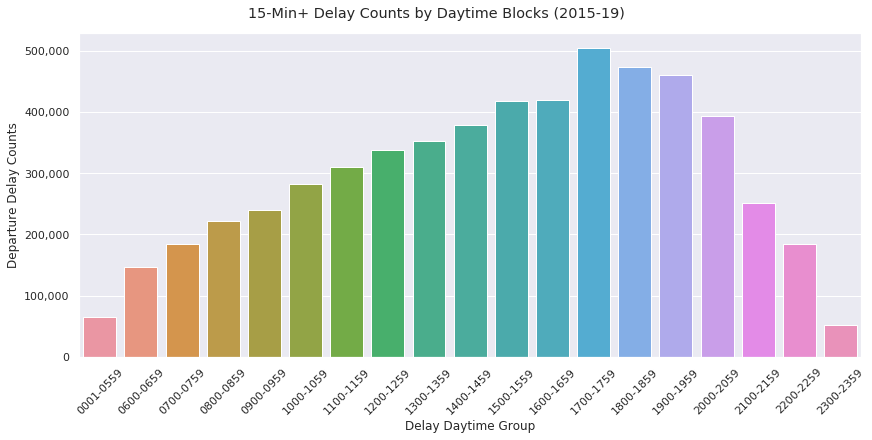

In [0]:
delay_daytime_blk_pddf = airlines_clean_full_df.select('DEP_TIME_BLK') \
                                               .where((f.col('CANCELLED') == 0) & 
                                                      (f.col('DEP_DEL15') == 1)).toPandas()
delay_daytime_blk_pddf = delay_daytime_blk_pddf.sort_values(by='DEP_TIME_BLK')

fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
fig.suptitle("15-Min+ Delay Counts by Daytime Blocks (2015-19)")
sns.countplot(x="DEP_TIME_BLK", data=delay_daytime_blk_pddf, ax=ax)

ax.set_xlabel("Delay Daytime Group")
ax.set_ylabel("Departure Delay Counts")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=45)
pass

#### Delay Propagation
From the first plot below, we see that for flights with departure delays under 3 hours, the points seem to be relatively scattered. Although for large departure delays (over 150mins) there is a stronger correlation with arrival delays, for shorter delays the points are quite scattered. This indicates that short delays can usually be overcome - presumably pilots are able to fly faster than they otherwise would had they been on time, allowing them to cut delays while in the air. However for large departure delays (150mins +), the higher correlation indicates that the delays are simply too long for the pilots to be able to gain significant time while in the air. This is further shown in the second plot, which examins the departure and arrival delays for flights with long delays. Although there is some crowding of points below 300 or 400 minutes of delay departure, beyond that the correlation between departure and arrival delay is nearly perfectly linear, showing that for these large departure delays the delay ends up propagating almost 1-to-1 into arrival delays.

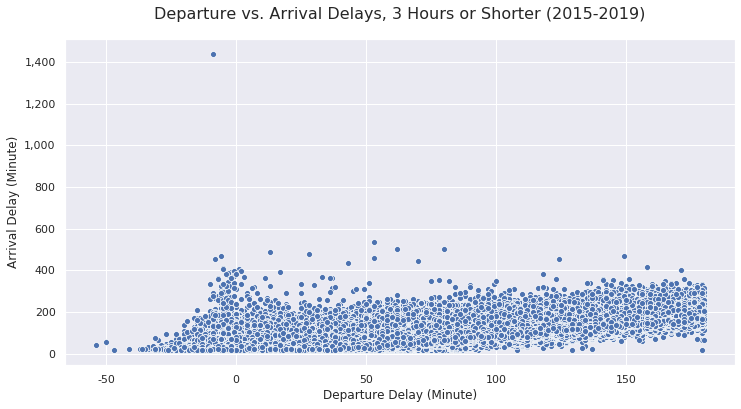

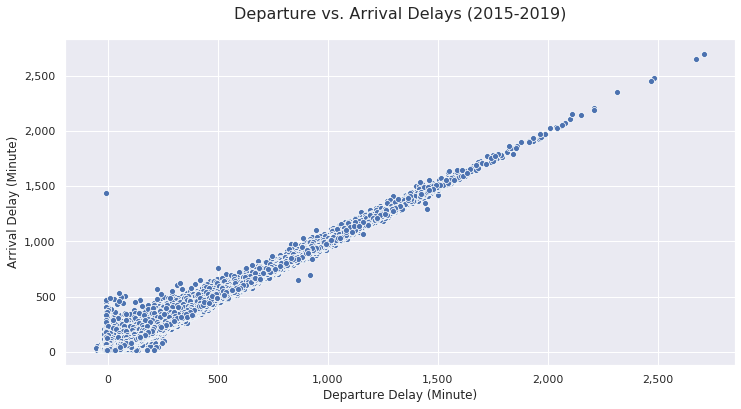

In [0]:
# pull relevant data
daa_clen_pddf = airlines_full_df.where(f.col('DEP_DELAY').isNotNull()) \
                                .select('DEP_DELAY', 'ARR_DELAY') \
                                .toPandas()

# 120 minutes or shorter delays
pddf = daa_clen_pddf.loc[daa_clen_pddf.DEP_DELAY <= 180, :]

fig, ax = plt.subplots(1, figsize=(12, 6))
corr = pddf.corr()
sns.scatterplot(data=pddf, x="DEP_DELAY", y="ARR_DELAY")

ax.set_title('Departure vs. Arrival Delays, 3 Hours or Shorter (2015-2019)', fontsize=16, pad=20)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
ax.set_xlabel("Departure Delay (Minute)")
ax.set_ylabel("Arrival Delay (Minute)")
pass

# all delays
pddf = daa_clen_pddf.loc[:, :]

fig, ax = plt.subplots(1, figsize=(12, 6))
corr = pddf.corr()
sns.scatterplot(data=pddf, x="DEP_DELAY", y="ARR_DELAY")

ax.set_title('Departure vs. Arrival Delays (2015-2019)', fontsize=16, pad=20)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
ax.set_xlabel("Departure Delay (Minute)")
ax.set_ylabel("Arrival Delay (Minute)")
pass

#### Long Delays Are NOT Just Long
As shown by the boxplot and table below, delay outliers are significantly longer than the "normal" delays (with some extreme delays over days). Upon further analysis, we find that flights with these extremely long delays aren't simply just delayed. An example is demonstrated by the flight summary table below. The first two rows of the table show that the same aircraft (tail number N918SW) is scheduled to depart at the same time in the same airport on the same day of the year. A closer look at the data reveals that the flight is scheduled to depart at 12:30 from IAD to SHD on 2019-03-14. Then, for some reason, the flight switches to a new destination, PBG. The plane flies to PBG, flies back, and finally follows its origina route and fly to SHD. The system then logs a 248 minutes delay. Since the initial routing of the flight was IAD-SHD, the IAD-PBG-IAD-SHD routing that the aircraft took is still technically recorded as a 'delay', since the origin and destination are the same as the initial routing. However, it is clear that this is not just a simple departure delay caused by the same factors that most other delayed departures suffer from. These logistical issues must be taken into account when examing departure delays. Therefore, delay outliers with need to be treated differently than standard delays in order to reduce bias.

Lastly, the bar chart at the end shows departure delays grouped by 15 minute bins, starting at 0-15 min and ending with 180+min delays. As easily visible, the number of occurrences for delay blocks decreases steadily, with the exception of the 180+min delays. As discussed above, the last group (180+min delays) require different treatment than the other 11 blocks due to the different nature of the delays.

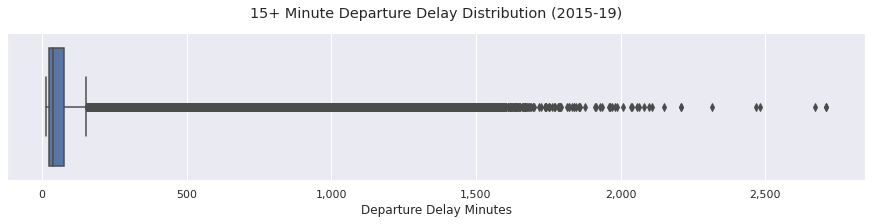

In [0]:
delay_distribution_pddf = airlines_clean_full_df.where(f.col('DEP_DELAY_NEW') >= 15).toPandas()

# plot delay distribution by minutes
fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)
fig.suptitle("15+ Minute Departure Delay Distribution (2015-19)")
sns.boxplot(delay_distribution_pddf['DEP_DELAY_NEW'])
ax.set_xlabel("Departure Delay Minutes")
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=0)
pass

In [0]:
"""Odd behaviors of flights with long delays.
"""
# show only rows with duplicate IDs
# ID: ORIGIN_AIRPORT_ID - TAIL_NUM - FL_DATE - CRS_DEP_TIME
duplicate_ids_df = airlines_full_df.select(['ID', 
                                            'FL_DATE', 
                                            'TAIL_NUM', 
                                            'OP_CARRIER_FL_NUM', 
                                            'ORIGIN_AIRPORT_ID', 
                                            'ORIGIN',
                                            'DEST_AIRPORT_ID',
                                            'DEST',
                                            'CRS_DEP_TIME',
                                            'DEP_TIME',
                                            'DEP_DELAY_NEW',
                                            'DEP_DELAY_GROUP',
                                            'CRS_ARR_TIME',
                                            'ARR_TIME',
                                            'ARR_DELAY_NEW',
                                            'CANCELLED',
                                            'DIVERTED',
                                            'AIR_TIME',
                                            'DISTANCE']) \
                                         .join(airlines_full_df.groupBy('ID') \
                                                          .count() \
                                                          .where('count = 1') \
                                                          .drop('count'), on='ID', how='left_anti')
print('Summary Table (2015-19): Delayed Flights with the Same CRS Departure Times & Airports')
display(duplicate_ids_df)

ID FL_DATE TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN DEST_AIRPORT_ID DEST CRS_DEP_TIME DEP_TIME DEP_DELAY_NEW DEP_DELAY_GROUP CRS_ARR_TIME ARR_TIME ARR_DELAY_NEW CANCELLED DIVERTED AIR_TIME DISTANCE 12266-N13979-2015-01-11-1431 2015-01-11 N13979 4863 12266 IAH 11140 CRP 1431 1428 0 -1 1534 1532 0.0 0 0 45.0 201 12266-N13979-2015-01-11-1431 2015-01-11 N13979 5790 12266 IAH 13158 MAF 1431 1748 197 12 1603 1956 233.0 0 0 67.0 429 14869-N603SK-2015-02-07-1125 2015-02-07 N603SK 4633 14869 SLC 12441 JAC 1125 1702 337 12 1233 1803 330.0 0 0 37.0 205 14869-N603SK-2015-02-07-1125 2015-02-07 N603SK 4461 14869 SLC 14893 SMF 1125 1122 0 -1 1216 1217 1.0 0 0 93.0 532 11433-N452SW-2015-02-12-1200 2015-02-12 N452SW 4666 11433 DTW 14150 PLN 1200 1549 229 12 1313 1705 232.0 0 0 47.0 243 11433-N452SW-2015-02-12-1200 2015-02-12 N452SW 7402 11433 DTW 11587 ESC 1200 1154 0 -1 1325 1309 0.0 0 0 54.0 306 10397-N837AS-2015-03-05-912 2015-03-05 N837AS 5244 10397 ATL 13277 MGM 912 1248 216 12 903 1237 214.0 0 0 33.0 147 10397-N837AS-2015-03-05-912 2015-03-05 N837AS 5171 10397 ATL 15323 TRI 912 909 0 -1 1012 1017 5.0 0 0 35.0 227 13930-N21197-2015-03-11-845 2015-03-11 N21197 5815 13930 ORD 14696 SBN 845 1129 164 10 1036 1302 146.0 0 0 17.0 84 13930-N21197-2015-03-11-845 2015-03-11 N21197 3958 13930 ORD 11977 GRB 845 843 0 -1 945 924 0.0 0 0 30.0 173 11292-N35271-2015-03-14-830 2015-03-14 N35271 1418 11292 DEN 11697 FLL 830 1010 100 6 1426 1548 82.0 0 0 202.0 1703 11292-N35271-2015-03-14-830 2015-03-14 N35271 1104 11292 DEN 12266 IAH 830 848 18 1 1154 1215 21.0 0 0 125.0 862 14747-N609SK-2015-03-20-2020 2015-03-20 N609SK 4536 14747 SEA 14057 PDX 2020 2012 0 -1 2115 2057 0.0 0 0 28.0 129 14747-N609SK-2015-03-20-2020 2015-03-20 N609SK 4560 14747 SEA 11884 GEG 2020 2305 165 11 2125 6 161.0 0 0 39.0 224 14869-N565SW-2015-04-12-1355 2015-04-12 N565SW 7438 14869 SLC 11525 EKO 1355 1706 191 12 1346 1714 208.0 0 0 45.0 200 14869-N565SW-2015-04-12-1355 2015-04-12 N565SW 7432 14869 SLC 15389 TWF 1355 1429 34 2 1442 1528 46.0 0 0 41.0 175 12191-N520SW-2015-04-17-1955 2015-04-17 N520SW 47 12191 HOU 13495 MSY 1955 2118 83 5 2055 2228 93.0 0 0 50.0 302 12191-N520SW-2015-04-17-1955 2015-04-17 N520SW 1181 12191 HOU 13158 MAF 1955 50 295 12 2120 203 283.0 0 0 63.0 441 11433-N893AT-2015-04-20-1545 2015-04-20 N893AT 1057 11433 DTW 11057 CLT 1545 1918 213 12 1730 2054 204.0 0 0 74.0 500 11433-N893AT-2015-04-20-1545 2015-04-20 N893AT 1284 11433 DTW 13342 MKE 1545 1541 0 -1 1555 1544 0.0 0 0 40.0 237 10397-N853AS-2015-05-04-905 2015-05-04 N853AS 5138 10397 ATL 10208 AGS 905 1300 235 12 955 1346 231.0 0 0 26.0 143 10397-N853AS-2015-05-04-905 2015-05-04 N853AS 5143 10397 ATL 14574 ROA 905 859 0 -1 1027 1017 0.0 0 0 60.0 357 11298-N675AE-2015-05-09-1030 2015-05-09 N675AE 2622 11298 DFW 11140 CRP 1030 1724 414 12 1158 1844 406.0 0 0 55.0 354 11298-N675AE-2015-05-09-1030 2015-05-09 N675AE 2627 11298 DFW 12191 HOU 1030 1031 1 0 1147 1154 7.0 0 0 48.0 247 11298-N374AA-2015-05-10-905 2015-05-10 N374AA 123 11298 DFW 12173 HNL 905 802 1377 12 1239 1204 1405.0 0 0 497.0 3784 11298-N374AA-2015-05-10-905 2015-05-10 N374AA 7 11298 DFW 13830 OGG 905 1149 164 10 1227 1552 205.0 0 0 508.0 3711 12191-N670SW-2015-05-15-800 2015-05-15 N670SW 668 12191 HOU 15370 TUL 800 816 16 1 930 939 9.0 0 0 71.0 453 12191-N670SW-2015-05-15-800 2015-05-15 N670SW 8 12191 HOU 11259 DAL 800 1412 372 12 900 1517 377.0 0 0 48.0 239 13930-N68802-2015-05-18-1225 2015-05-18 N68802 1251 13930 ORD 13485 MSN 1225 1221 0 -1 1320 1317 0.0 0 0 27.0 108 13930-N68802-2015-05-18-1225 2015-05-18 N68802 1711 13930 ORD 11292 DEN 1225 2046 501 12 1404 2213 489.0 0 0 128.0 888 13487-N936SW-2015-06-05-1120 2015-06-05 N936SW 4699 13487 MSP 14457 RAP 1120 1351 151 10 1207 1428 141.0 0 0 78.0 489 13487-N936SW-2015-06-05-1120 2015-06-05 N936SW 7399 13487 MSP 12129 HIB 1120 1118 0 -1 1222 1221 0.0 0 0 35.0 174 11292-N824AS-2015-06-07-1940 2015-06-07 N824AS 6413 11292 DEN 11637 FAR 1940 120 340 12 2232 406 334.0 0 0 92.0 627 112

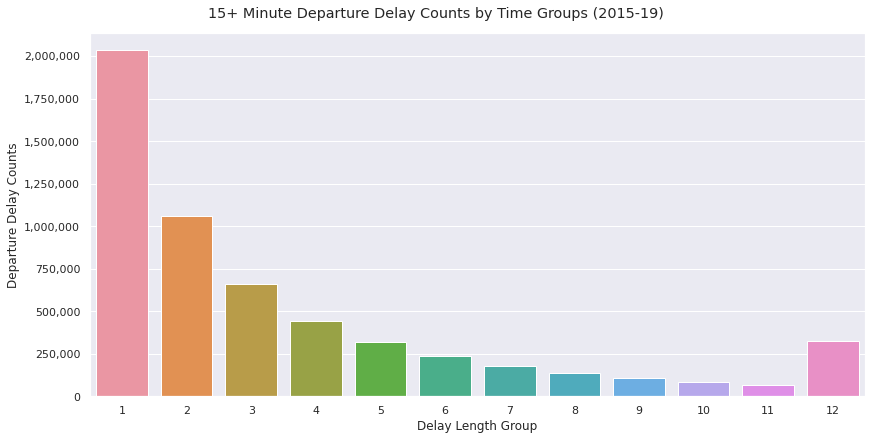

Note: Each group is a 15-minute delay interval, with Group 1 being 15~30 minutes, and Group 12 being > 180)

In [0]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
fig.suptitle("15+ Minute Departure Delay Counts by Time Groups (2015-19)")
sns.countplot(x="DEP_DELAY_GROUP", data=delay_distribution_pddf, ax=ax)

ax.set_xlabel("Delay Length Group")
ax.set_ylabel("Departure Delay Counts")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=0)

plt.show()
print('Note: Each group is a 15-minute delay interval, with Group 1 being 15~30 minutes, and Group 12 being > 180)')
pass

#### Delay Seasonality
From the plots below, we see that delays and cancellations are affected by season. Delay ratios and counts hit their maximum each year during the summer months (June, July and August), and also have secondary peaks during the winter months (December, January). This is to be expected, with summer months having high traffic due to holidays, and winter months also experience high traffic due to holidays but also having the possibility of weather related (ice, snow etc) delays. For each year, the months with the lowest amounts of delay seem to be in September and November, corresponding to low season in travel. During these months, delay ratios range roughly from 0.12 to 0.15, just over half of that of the peak months, which range approximately from 0.20 to 0.25. Cancellations show the same overall behavior graphically as the delays, hitting peaks around summer months, and having secondary peaks in December, although December peaks seem to be somewhat lower than December delay peaks.

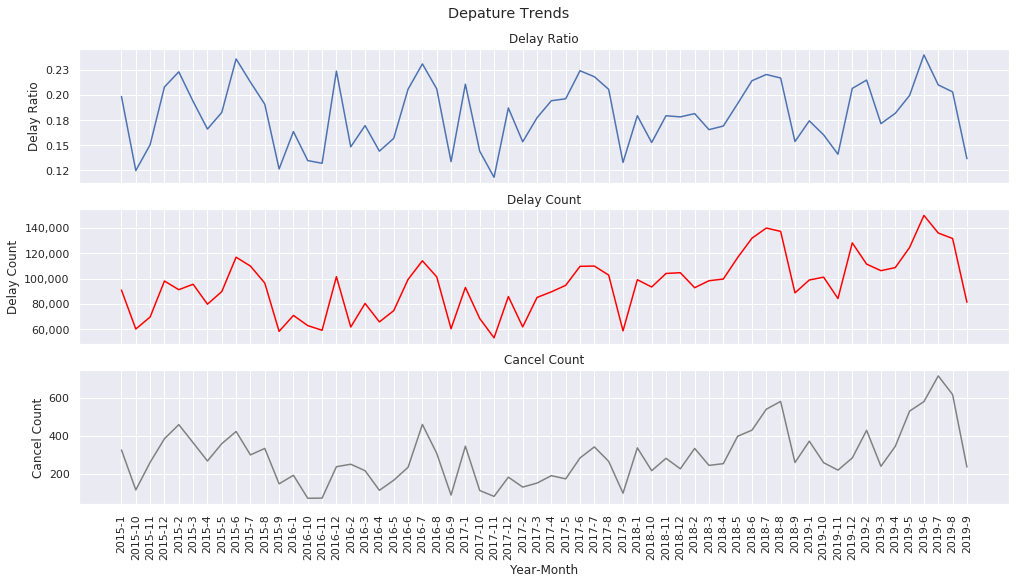

In [0]:
# select eda df
airlines_eda_df = airlines_full_df

# pull depature delay df
airlines_eda_df.createOrReplaceTempView('eda_air')
dep_pddf = sqlContext.sql('SELECT \
                              YEAR, \
                              MONTH, \
                              DEP_TIME, \
                              DEP_DELAY, \
                              DEP_DELAY_NEW, \
                              DEP_DEL15, \
                              DEP_DELAY_GROUP, \
                              DEP_TIME_BLK, \
                              CANCELLED, \
                              DIVERTED \
                           FROM \
                              eda_air').toPandas()
dep_pddf = dep_pddf.dropna()

# add YEAR_MONTH column
dep_pddf['YEAR_MONTH'] = dep_pddf['YEAR'].astype('str') + '-' + dep_pddf['MONTH'].astype('str')
dep_trend_pddf = dep_pddf.groupby(['YEAR', 'MONTH', 'YEAR_MONTH']).aggregate(np.sum)
dep_trend_pddf = dep_trend_pddf.reset_index()

# add MONTH_DEP_RATIO
count_df = dep_pddf.groupby(['YEAR_MONTH']).aggregate('count').reset_index()
dep_trend_pddf['MONTH_COUNT'] = dep_trend_pddf['YEAR_MONTH'].map(lambda x: count_df.loc[count_df.YEAR_MONTH == x, ['MONTH']].values[0][0])
dep_trend_pddf['MONTH_DEP_RATIO'] = dep_trend_pddf['DEP_DEL15'] / dep_trend_pddf['MONTH_COUNT']

# plot
fig, ax = plt.subplots(3, figsize=(14, 8), sharex=True, constrained_layout=True)
fig.suptitle('Depature Trends')
sns.lineplot(
        x='YEAR_MONTH', 
        y='MONTH_DEP_RATIO', 
        data=dep_trend_pddf,
        ax=ax[0],
        markers=True, 
        dashes=False)
sns.lineplot(
        x='YEAR_MONTH', 
        y='DEP_DEL15', 
        data=dep_trend_pddf,
        ax=ax[1],
        markers=True, 
        dashes=False,
        color='red')
sns.lineplot(
        x='YEAR_MONTH', 
        y='CANCELLED', 
        data=dep_trend_pddf,
        ax=ax[2],
        markers=True, 
        dashes=False,
        color='grey')
ax[0].set_title('Delay Ratio')
ax[0].set_xlabel("Year-Month")
ax[0].set_ylabel("Delay Ratio")
ax[0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.2f}")) 
ax[1].set_title('Delay Count')
ax[1].set_xlabel("Year-Month")
ax[1].set_ylabel("Delay Count")
ax[1].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
ax[2].set_title('Cancel Count')
ax[2].set_xlabel("Year-Month")
ax[2].set_ylabel("Cancel Count")
ax[2].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=90)
pass

#### Why Do Flights Get Delayed?
The following plot visualizes the cause of each 15+min delay. Here, the causes are split into 5 categories - carrier delay, weather delay, national aviation system delay, security delay, and late aircraft delay. Carrier delay refers to carrier-related causes that are within the airline's control (crew or maintenance issues, baggage loading, passenger boarding etc). Weather delay refers to meteorological causes (extreme winds, poor visibility, snow, ice etc). National aviation system delay refers to a variety of logistical causes (airport congestion and traffic, air traffic control-related issues, airport operations etc). Security delay refers to safety related causes (breach in passenger screening, evacuations, incidents within the airport etc). Late aircraft delay refers to the incoming aircraft being delayed. It is clear from the plot that carrier related, national aviation system related, and late aircraft related causes are significant, with late incoming aircraft being the largest cause behind departure delays. Contrary to our initial expectations, weather delays are actually quite low, being only approximately 10% as prevalent as late aircraft delays. Security delays are even more rare, with the corresponding bar below being essentially invisible. Based on this analysis, airline and airport related features, as well as tracking previous incoming flights seems to be a promising direction in building highly predictive and powerful features.

In [0]:
# select eda df
airlines_eda_df = airlines_full_df

# pull depature delay df
airlines_eda_df.createOrReplaceTempView('eda_air')
daa_pddf = sqlContext.sql(' \
                      SELECT \
                        OP_UNIQUE_CARRIER, \
                        ORIGIN, \
                        DEST, \
                        CARRIER_DELAY, \
                        WEATHER_DELAY, \
                        NAS_DELAY, \
                        SECURITY_DELAY, \
                        LATE_AIRCRAFT_DELAY, \
                        DEP_DELAY, \
                        DEP_DELAY_NEW, \
                        DEP_DEL15, \
                        ARR_DELAY, \
                        ARR_DELAY_NEW, \
                        ARR_DEL15 \
                      FROM \
                        eda_air').toPandas()
daa_clen_pddf = daa_pddf.dropna()

count_flight = daa_pddf.shape[0]
count_delay = daa_pddf.loc[daa_pddf.DEP_DELAY_NEW > 0,:].shape[0]
count_delay_15min = daa_pddf.loc[daa_pddf.DEP_DELAY_NEW >= 15,:].shape[0]
count_delay_15min_breakdown = daa_clen_pddf.loc[daa_pddf.DEP_DELAY_NEW >= 15,:].shape[0]

print('Airlines Delay Stats (2015-19)')
print('Total # of flights: {:,}'.format(count_flight))
print('% of flights delayed: {:.2f}%'.format(count_delay/count_flight * 100))
print('% of flights delayed 15 minutes or more: {:.2f}%'.format(count_delay_15min/count_flight * 100))
print('% of 15-minute+ delays with breakdown: {:.2f}%'.format(count_delay_15min_breakdown/count_delay_15min * 100))

Airlines Delay Stats (2015-19)
Total # of flights: 31,746,841
% of flights delayed: 34.54%
% of flights delayed 15 minutes or more: 17.93%
% of 15-minute+ delays with breakdown: 79.35%

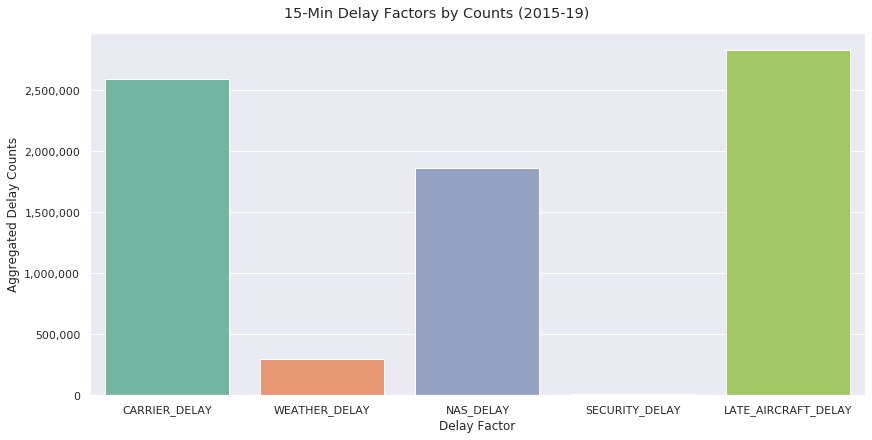

In [0]:
pddf = daa_clen_pddf.drop(columns=['ORIGIN', 'DEST', 'ARR_DEL15', 'OP_UNIQUE_CARRIER',
                                   'ARR_DELAY_NEW', 'DEP_DELAY', 'ARR_DELAY'])
pddf.loc[:, ['CARRIER_DELAY', 
             'WEATHER_DELAY', 
             'NAS_DELAY', 
             'SECURITY_DELAY', 
             'LATE_AIRCRAFT_DELAY']] = pddf.iloc[:,0:5].applymap(lambda x: 1 if x > 0 else 0)
pddf = pddf.loc[pddf.DEP_DEL15 > 0,] # filter for 15 min delays only
pddf = pddf.aggregate(np.sum)

# bar chart
pddf_plot =  pddf.drop(['DEP_DELAY_NEW', 'DEP_DEL15'])
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
fig.suptitle("15-Min Delay Factors by Counts (2015-19)")
sns.barplot(x=pddf_plot.index, y=pddf_plot, palette=sns.color_palette("Set2"))
ax.set_xlabel("Delay Factor")
ax.set_ylabel("Aggregated Delay Counts")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=0)
pass

####Correlation Matrix
The following correlation heatmap shows the five delay causes from above correlated with the variable we want to predict (DEP_DEL15). From the rightmost column, we can see that late aircraft delay has the highest linear correlation with DEP_DEL15 (0.27), while the others have weaker correlation and NAS_DELAY even having a surprising negative correlation with DEP_DEL15.

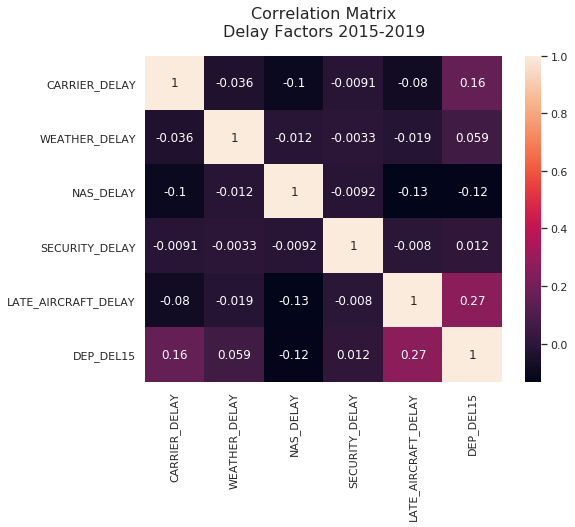

In [0]:
pddf = daa_clen_pddf.drop(columns=['ORIGIN', 'DEST', 'ARR_DEL15', 
                                   'DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'DEP_DELAY', 'ARR_DELAY'])

# plot correlation
fig, ax = plt.subplots(1, figsize=(8, 6))
corr = pddf.corr()
sns.heatmap(corr, annot=True, ax=ax)
ax.set_title('Correlation Matrix\nDelay Factors 2015-2019', fontsize=16, pad=20)
pass

#### Flights Missing Key Information
We found a fair number of records with invalid departure/arrival time or delay information in the dataset. Most of these correspond to cancelled or diverted flights. The distribution of diverted and cancelled flights are summarized below. The two types of flights are inherently different from on-time/non-diverted flights, and the inclusion of which in training can result in a bias in our final predictive model. Fortunately, as shown by the summary below, these flights only contribute to a small portion of the Airlines dataset and will be removed during data cleaning.

As a result of the data removal, our final model will produce inaccurate predictions for cancelled and diverted flights. The consequence, however, is justified since cancelled and diverted flights have inherently different impacts from delayed flights, and are handled differently by airports and airlines in practice. Additionally, variables that predict delay do not necessarily predict cancellations and diversion as well. Building a model to predict cancellations and diversion would likely require features that are different from features used to predict delays.

In [0]:
total = airlines_full_df.count()
cl_df = airlines_full_df.where(f.col('DIVERTED') == 1)
dv_df = airlines_full_df.where(f.col('CANCELLED') == 1)
print('Total Number of Flights: {:,.0f}'.format(total))
print('Number of Cancelled Flights: {:,.4f}%'.format(cl_df.count()/total))
print('Number of Diverted Flights: {:,.4f}%'.format(dv_df.count()/total))

Total Number of Flights: 31,746,841
Number of Cancelled Flights: 0.0025%
Number of Diverted Flights: 0.0154%

### EDA - Airports

#### Where Are the Airports?
We visualize the locations of the airports on the world map. This helps us understand not just where the airports in the airline dataset are but also how far an airport can be from another. In particular, note that some flights can have a travel distance equivalent of an international flight because airports in the five US territories are included.

In [0]:
"""Locate all airports and all weather stations on map.
"""
stations_all_df = spark.read.option("header", "true").parquet('dbfs:/team_30/weather_stations_full_02.parquet')
stations_all_pddf = stations_all_df.toPandas()

awm_pddf = air_station_map_df.toPandas()
awm_pddf = awm_pddf.astype({'AIRPORT_ID': int})
awm_pddf = awm_pddf.sort_values(by='Distance', ascending=True)
awm_pddf = awm_pddf.groupby(awm_pddf.AIRPORT_ID).first().reset_index()
awm_pddf = awm_pddf.sort_values(by='Distance', ascending=True).loc[:, ['AIRPORT_ID', 
                                                                       'W_USAF',
                                                                       'W_WBAN',
                                                                       'W_Lat', 
                                                                       'W_Lon', 
                                                                       'A_Lat', 
                                                                       'A_Lon',
                                                                       'Distance']]
awm_pddf['Distance'] = round(awm_pddf['Distance'], 2)
awm_pddf = awm_pddf.reset_index()

ZOOM = 2
MAP_CENTER = [50, -140]
MAP_CENTER = {'lat': MAP_CENTER[0], 'lon': MAP_CENTER[1]}
MAP_STYLE = 'carto-positron'
W = 1000
H = 600

# airports
fig = go.Figure()
fig.add_trace(
    go.Scattermapbox(mode = "markers",
                     lat = awm_pddf['A_Lat'],
                     lon = awm_pddf['A_Lon'],
                     text = awm_pddf['AIRPORT_ID'].astype('str'),
                     hoverinfo='text',
                     name='Airports',
                     showlegend = True,
                     marker = dict(size=7, color='lightcoral')))

fig.update_layout(
    autosize = False,
    width = W,
    height = H,
    margin = {'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': MAP_CENTER,
        'style': MAP_STYLE,
        'zoom': ZOOM},
    legend = {
        'orientation': "h",
        'yanchor': 'bottom',
        'xanchor': 'left',
        'y': 1.02}
)
fig.show()

#### Moving Airports!?
Multiple airports changed their coordinates over time. This section goes in depth to determine if an airport with historically different coordinates have "actually" moved. The table below shows the top five distances that airports have "moved" over. The top three distances are roughly 1.5 km while all others are shorter than 1 km. The most likely explanation for this is that the representative coordinates used for these airports simply moved to another location within the airport's grounds (for example, the air traffic control tower may be used as the representative coordinates for that airport - if a new tower is built to replace an aging tower, the representative coordinates may be moved to the new tower, which will be slightly off from the previous coordinates). We conclude that all historical airport coordinate differences in our dataset are miniscule and can be safely ignored. Airport locations in our analysis and models will be determined simply based on their latest coordinates as reported by BTS.

In [0]:
def haversine(Olat: float, 
              Olon: float, 
              Dlat: float, 
              Dlon: float) -> float:
    """Function to calculate the distance between to coordinates using Haversine.
    """
    radius = 6371.  # km

    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    d = radius * c
    
    return d
  
# pull airport master
airport_master_pddf = airport_master_df.toPandas()
airport_master_pddf = airport_master_pddf.loc[airport_master_pddf.AIRPORT_COUNTRY_CODE_ISO == 'US', :]
airport_master_pddf = airport_master_pddf.loc[:, ['AIRPORT_SEQ_ID',
                                                  'AIRPORT_ID', 
                                                  'AIRPORT', 
                                                  'DISPLAY_AIRPORT_NAME', 
                                                  'LATITUDE', 
                                                  'LONGITUDE', 
                                                  'AIRPORT_COUNTRY_CODE_ISO']].dropna()
airport_master_pddf = airport_master_pddf.reset_index(drop=True)

# pull airports
airlines_full_df.createOrReplaceTempView("airlines_full")
origin_airports_pddf = sqlContext.sql(' \
                                    SELECT \
                                        DISTINCT ORIGIN_AIRPORT_SEQ_ID, \
                                        FIRST_VALUE(ORIGIN_AIRPORT_ID) AS ORIGIN_AIRPORT_ID, \
                                        MIN(YEAR) AS YEAR_EARLIEST, \
                                        MIN(MONTH) AS MONTH_EARLIEST, \
                                        FIRST_VALUE(ORIGIN) AS ORIGIN, \
                                        FIRST_VALUE(ORIGIN_CITY_NAME) AS ORIGIN_CITY_NAME, \
                                        FIRST_VALUE(ORIGIN_STATE_ABR) AS ORIGIN_STATE_ABR\
                                    FROM \
                                        airlines_full \
                                    GROUP BY \
                                        ORIGIN_AIRPORT_SEQ_ID \
                                    ORDER BY \
                                        ORIGIN_AIRPORT_SEQ_ID').toPandas()
origin_airports_pddf = origin_airports_pddf.sort_values(by=['ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_AIRPORT_ID', 'YEAR_EARLIEST', 'MONTH_EARLIEST'])

# merge
origin_airports_pddf = origin_airports_pddf.astype({'ORIGIN_AIRPORT_SEQ_ID': 'str'})
airport_master_pddf = airport_master_pddf.astype({'AIRPORT_SEQ_ID': 'str'})
airports_pddf = pd.merge(origin_airports_pddf, airport_master_pddf, left_on='ORIGIN_AIRPORT_SEQ_ID', right_on='AIRPORT_SEQ_ID', how='left', sort=True)
airports_pddf = airports_pddf.drop(columns='AIRPORT_ID')
airports_pddf = airports_pddf.astype({'LATITUDE': 'float', 'LONGITUDE': 'float'})

# prep airport df
df = airports_pddf.set_index(['ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID'])
df = df.sort_index()
df = df.loc[:, ['LATITUDE', 'LONGITUDE']]
df['DISTANCE_KM'] = 0

# loop through each ORIGIN_AIRPORT_ID
for idx in df.index.levels[0]:
    # extract index 0, ORIGIN_AIRPORT_ID
    Olat = df.loc[(idx),].LATITUDE.iloc[0,]
    Olon = df.loc[(idx),].LONGITUDE.iloc[0,]
    
    # loop through all rows within each ORIGIN_AIRPORT_ID
    for i in range(0, df.loc[(idx),].shape[0]):
        # extract index i
        Dlat = df.loc[(idx),].LATITUDE.iloc[i,]
        Dlon = df.loc[(idx),].LONGITUDE.iloc[i,]
        
        # calculate & store distance
        idx2 = df.loc[(idx),].iloc[i,].name # ORIGIN_AIRPORT_SEQ_ID	
        d = haversine(Olat,Olon, Dlat,Dlon)
        df.loc[(idx, idx2), 'DISTANCE_KM'] = d
    
# flattern df
df = pd.DataFrame(df.to_records())

# print df
print('Top Airport Moving Distances:')
df = df.sort_values(['DISTANCE_KM'], ascending=False)
HTML(df.head(5).to_html(index=False))

Top Airport Moving Distances:
Out[170]:

ORIGIN_AIRPORT_ID 
 ORIGIN_AIRPORT_SEQ_ID 
 LATITUDE 
 LONGITUDE 
 DISTANCE_KM 
 
 
 
 
 11413 
 1141306 
 37.163889 
 -107.742222 
 1.732301 
 
 
 11413 
 1141304 
 37.163889 
 -107.742222 
 1.732301 
 
 
 11503 
 1150304 
 39.642778 
 -106.932500 
 1.427071 
 
 
 10165 
 1016506 
 51.883611 
 -176.642500 
 0.665622 
 
 
 10165 
 1016504 
 51.883611 
 -176.642500 
 0.665622

#### Airport Stress PageRank
An analysis of airport stress PageRanks is shown below. Each airport is used as a vertex, and the relative importance of the airports are visualized. As expected, large hubs (ATL, ORD, SFO, LAX, DFW, IAH, EWR, JFK etc) are labelled as heavily important. The vertex and edge counts indicate that there are 360 airports and 7,287,112 flights in our data.

In [0]:
"""Build the GraphFrame Object.
"""
AIRLINE_DF = airlines_2019_df
AIRPORT_MASTER_DF = airport_master_df

# pull airport master
airport_master_pddf = AIRPORT_MASTER_DF.toPandas()
airport_master_pddf = airport_master_pddf.loc[airport_master_pddf.AIRPORT_COUNTRY_CODE_ISO == 'US', :] \
                                         .loc[:, ['AIRPORT_SEQ_ID',
                                                  'AIRPORT_ID', 
                                                  'AIRPORT', 
                                                  'DISPLAY_AIRPORT_NAME', 
                                                  'LATITUDE', 
                                                  'LONGITUDE', 
                                                  'AIRPORT_COUNTRY_CODE_ISO']].dropna()

# reduce to the last row within each AIRPORT_ID
airport_master_pddf = airport_master_pddf.sort_values(by='AIRPORT_SEQ_ID') \
                                         .groupby('AIRPORT_ID').last() \
                                         .reset_index()
airport_master_pddf = airport_master_pddf.loc[:, ['AIRPORT_ID', 'LATITUDE', 'LONGITUDE']]

# load air_graph and joing the airport coordinates
AIRLINE_DF.createOrReplaceTempView("air_graph_2019")
air_graph_pddf = sqlContext.sql(' \
                                    SELECT \
                                        CANCELLED, \
                                        DEP_DELAY_NEW, \
                                        DEP_DELAY, \
                                        \
                                        ORIGIN_AIRPORT_ID, \
                                        ORIGIN, \
                                        ORIGIN_CITY_NAME, \
                                        ORIGIN_STATE_ABR, \
                                        \
                                        DEST_AIRPORT_ID, \
                                        DEST, \
                                        DEST_CITY_NAME, \
                                        DEST_STATE_ABR \
                                    FROM \
                                        air_graph_2019 \
                                    ORDER BY \
                                        DEP_TIME').toPandas()
airport_master_pddf.columns = ['AIRPORT_ID', 'LATITUDE_ORIGIN', 'LONGITUDE_ORIGIN']

# convert datatypes
airport_master_pddf = airport_master_pddf.astype({'AIRPORT_ID': 'str'})
air_graph_pddf = air_graph_pddf.astype({'ORIGIN_AIRPORT_ID': 'str', 'DEST_AIRPORT_ID': 'str'})

# merge
air_graph_pddf = pd.merge(air_graph_pddf, airport_master_pddf, left_on='ORIGIN_AIRPORT_ID', right_on='AIRPORT_ID', how='left', sort=True)
airport_master_pddf.columns = ['AIRPORT_ID', 'LATITUDE_DEST', 'LONGITUDE_DEST']
air_graph_pddf = pd.merge(air_graph_pddf, airport_master_pddf, left_on='DEST_AIRPORT_ID', right_on='AIRPORT_ID', how='left', sort=True)

# reduce air_graph & save to csv
aag_reduce_pddf = air_graph_pddf.loc[:, ['CANCELLED',
                                         'DEP_DELAY_NEW',
                                         'ORIGIN_AIRPORT_ID', 
                                         'DEST_AIRPORT_ID', 
                                         'ORIGIN', 
                                         'ORIGIN_STATE_ABR',
                                         'DEST', 
                                         'DEST_STATE_ABR',
                                         'LATITUDE_ORIGIN', 
                                         'LONGITUDE_ORIGIN', 
                                         'LATITUDE_DEST', 
                                         'LONGITUDE_DEST']]
aag_reduce_pddf = aag_reduce_pddf.loc[aag_reduce_pddf.CANCELLED == 0,:]
air_graph_df = sqlContext.createDataFrame(aag_reduce_pddf) 

In [0]:
"""Print vertice & edge counts for the GraphFrame object.
"""
air_graph_df.createOrReplaceTempView("air_graph")
vertices_df = sqlContext.sql(' \
                        SELECT \
                            ORIGIN_AIRPORT_ID AS id, \
                            FIRST(ORIGIN) AS origin, \
                            FIRST(LATITUDE_ORIGIN) AS latitude, \
                            FIRST(LONGITUDE_ORIGIN) AS longitude \
                        FROM \
                            air_graph \
                        GROUP BY \
                            ORIGIN_AIRPORT_ID').cache()

edges_df = sqlContext.sql(' \
                        SELECT \
                            DEP_DELAY_NEW      AS delay, \
                            ORIGIN_AIRPORT_ID  AS src, \
                            DEST_AIRPORT_ID    AS dst, \
                            ORIGIN             AS src_airport, \
                            DEST               AS dst_airport, \
                            ORIGIN_STATE_ABR   AS src_state, \
                            DEST_STATE_ABR     AS dst_state, \
                            LATITUDE_ORIGIN    AS src_latitude, \
                            LONGITUDE_ORIGIN   AS src_longitude, \
                            LATITUDE_DEST      AS dst_latitude, \
                            LONGITUDE_DEST     AS dst_longitude \
                        FROM \
                            air_graph').cache()

# build object and print basic info
air_gf = GraphFrame(vertices_df, edges_df)
print (f'Vertice Count (Airport): {air_gf.vertices.count():,.0f}')
print (f'Edge Count (Flight): {air_gf.edges.count():,.0f}')

Vertice Count (Airport): 360
Edge Count (Flight): 7,287,112

In [0]:
"""PageRank training.
"""
# training
page_ranks_df = air_gf.pageRank(resetProbability=0.15, maxIter=5)

# convert pr df to pandas
page_ranks_pddf = page_ranks_df.vertices.orderBy(page_ranks_df.vertices.pagerank.desc()).toPandas()

# normalize and round off page rank
page_ranks_pddf['pr_normal'] = page_ranks_pddf['pagerank'] / page_ranks_pddf['pagerank'].max()
page_ranks_pddf['pr_normal'] = page_ranks_pddf['pr_normal'].round(2)

# label for the plot
page_ranks_pddf['label'] = page_ranks_pddf['origin'] + \
                           ', ID: ' + page_ranks_pddf['id'].astype('str') + \
                           ', PR: ' + page_ranks_pddf['pr_normal'].astype('str')

# style configs
ZOOM = 2
MARK_SIZE = 50
MARK_COLOR = "orange"
MAP_CENTER = [50, -140]
MAP_CENTER = {'lat': MAP_CENTER[0], 'lon': MAP_CENTER[1]}
MAP_STYLE = 'carto-positron'
W = 1000
H = 600

fig = go.Figure()
fig.add_trace(
        go.Scattermapbox(mode = "markers",
                         lon = page_ranks_pddf['longitude'],
                         lat = page_ranks_pddf['latitude'],
                         text = page_ranks_pddf['label'],
                         showlegend = False,
                         marker = dict(size=MARK_SIZE * page_ranks_pddf['pr_normal'], color=MARK_COLOR)))
fig.update_layout(
    autosize = False,
    width = W,
    height = H,
    margin = {'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': MAP_CENTER,
        'style': MAP_STYLE,
        'zoom': ZOOM})
fig.show()

#### Airport Transfer Degrees
In this section, we examine the degree of an airport being a transfer point. The transfer degree is calculated by the following equation: **transfer degree = in-degree / out-degree**. Esentially we are calculating the ratio of flights "flying to" over "leaving from" an airport. The closer the transfer degress it to 1, the more likely the airport is acting as a transfer point. Apart from 2 outliers, all airports are within 3% of the 1.0 base value. Larger airports with more flights tend to increasingly get closer to 1.0.

In [0]:
in_deg = air_gf.inDegrees
out_deg = air_gf.outDegrees

transfer_deg_df = in_deg.join(out_deg, in_deg.id == out_deg.id) \
    .drop(out_deg.id) \
    .selectExpr('id', 
                'inDegree as in_degree', 
                'outDegree as out_degree', 
                'double(inDegree) + double(outDegree) as total_deg',
                'double(inDegree)/double(outDegree) as transfer_deg') \
    .cache()

# add transfer degree to page_ranks_pddf
transfer_deg_pddf = transfer_deg_df.toPandas()
transfer_deg_pddf = pd.merge(page_ranks_pddf, transfer_deg_pddf, left_on='id', right_on='id', how='left')

# sort & save
transfer_deg_pddf = transfer_deg_pddf.sort_values(by='total_deg', ascending=False)
transfer_deg_pddf.to_csv(f'{ROOT_TEAM30_DBFS}/airport_graph_summary_2019.csv', index=False)
transfer_deg_pddf

Out[284]:

id 
 origin 
 latitude 
 longitude 
 pagerank 
 pr_normal 
 label 
 in_degree 
 out_degree 
 total_deg 
 transfer_deg 
 
 
 
 
 0 
 10397 
 ATL 
 33.636667 
 -84.427778 
 17.541039 
 1.00 
 ATL, ID: 10397, PR: 1.0 
 392525 
 392603 
 785128.0 
 0.999801 
 
 
 1 
 13930 
 ORD 
 41.974444 
 -87.906667 
 16.006042 
 0.91 
 ORD, ID: 13930, PR: 0.91 
 328563 
 329045 
 657608.0 
 0.998535 
 
 
 2 
 11298 
 DFW 
 32.897222 
 -97.037778 
 15.805587 
 0.90 
 DFW, ID: 11298, PR: 0.9 
 296070 
 296449 
 592519.0 
 0.998722 
 
 
 3 
 11292 
 DEN 
 39.861667 
 -104.673056 
 12.556035 
 0.72 
 DEN, ID: 11292, PR: 0.72 
 246911 
 247175 
 494086.0 
 0.998932 
 
 
 4 
 11057 
 CLT 
 35.213611 
 -80.949167 
 10.390477 
 0.59 
 CLT, ID: 11057, PR: 0.59 
 231361 
 231855 
 463216.0 
 0.997869 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 358 
 12250 
 HYA 
 41.669444 
 -70.280278 
 0.152679 
 0.01 
 HYA, ID: 12250, PR: 0.01 
 83 
 83 
 166.0 
 1.000000 
 
 
 348 
 11336 
 DLG 
 59.044722 
 -158.505556 
 0.160764 
 0.01 
 DLG, ID: 11336, PR: 0.01 
 82 
 82 
 164.0 
 1.000000 
 
 
 337 
 11997 
 GST 
 58.425278 
 -135.707500 
 0.169872 
 0.01 
 GST, ID: 11997, PR: 0.01 
 82 
 82 
 164.0 
 1.000000 
 
 
 359 
 14092 
 PGV 
 35.635556 
 -77.384167 
 0.152606 
 0.01 
 PGV, ID: 14092, PR: 0.01 
 77 
 77 
 154.0 
 1.000000 
 
 
 353 
 10245 
 AKN 
 58.676389 
 -156.648611 
 0.158008 
 0.01 
 AKN, ID: 10245, PR: 0.01 
 61 
 60 
 121.0 
 1.016667 
 
 
 
 360 rows × 11 columns

### EDA - Weather

#### Empty Weather Dataset!?
Although the weather dataset contains over 600 million entries, upon further analysis we see that the vast majority of them contain significant amounts of null values. Fortunately, most of the features with empty data are complementary to the features of our interest according to the documentation provided by NCEI. They are irrelevant for modeling and can be safely excluded during data cleaning.

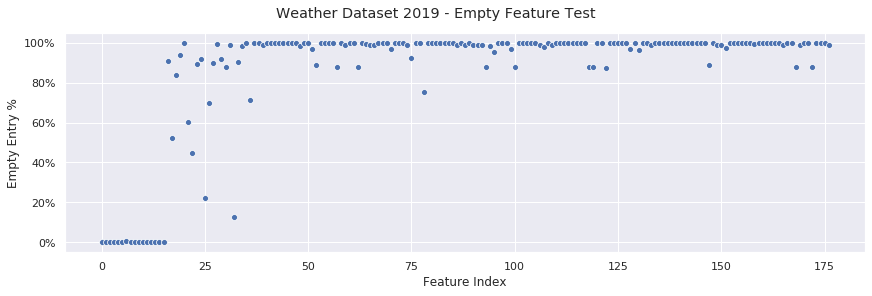

In [0]:
df = weather_2019_df

# get empty counts per column
col_empty_counts = {}
for column in df.columns:
    col_empty_counts[column] = df.select(column).where(f.col(column)=='').count()  

# get total count
count_weather = df.count()

# prep pddf
cec_pddf = pd.DataFrame(col_empty_counts, index=['count']).T
cec_pddf = cec_pddf / count_weather * 100

# plot data
fig, ax = plt.subplots(1, figsize=(12, 4), sharex=True, constrained_layout=True)
fig.suptitle('Weather Dataset 2019 - Empty Feature Test')
sns.scatterplot(
        x=list(range(0, cec_pddf.shape[0])),
        y=cec_pddf['count'],
        ax=ax,
        markers=True)
ax.set_xlabel("Feature Index")
ax.set_ylabel("Empty Entry %")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}%")) 
pass

#### Where Are the Weather Stations?
The weather stations are scattered globally. Since our flight data only concerns domestic US flights, the weather stations outside of the US are not relevant for us, and will therefore be removed. In addition, we observe that almost all airports come with a weather station either right in the airport or nearby by within a reasonable radius. Our research shows that a radius of 50KM is appropriate for reiterativing relevant weather station and so we are confident that weather information should be readily available for prediction for most of the flights.

In [0]:
display(stations_all_pddf)

usaf wban name country state call lat lon elev begin end 007018 99999 WXPOD 7018 null null null 0 0 +7018.0 20110309 20130730 007026 99999 WXPOD 7026 AF null null 0 0 +7026.0 20120713 20170822 007070 99999 WXPOD 7070 AF null null 0 0 +7070.0 20140923 20150926 008268 99999 WXPOD8278 AF null null 32.95 65.567 +1156.7 20100519 20120323 008307 99999 WXPOD 8318 AF null null 0 0 +8318.0 20100421 20100421 010016 99999 RORVIK/RYUM NO null null 64.85 11.233 +0014.0 19870116 19910806 010017 99999 FRIGG NO null ENFR 59.98 2.25 +0048.0 19880320 20050228 010071 99999 LONGYEARBYEN SV null null 78.217 15.583 +0037.0 20050210 20050210 010190 99999 SVARTTANGEN NO null null 77.517 20.817 +0020.0 20100825 20140523 010303 99999 TROMSO/SKATTURA NO null null 69.7 19.017 +0014.0 20140522 20150108 010320 99999 OVERBYGD NO null null 69.017 19.283 +0078.0 19730101 20140523 010340 99999 FUGLOYKALVEN FYR NO null null 70.317 20.15 +0038.0 19871202 20140523 010510 99999 SUOLOVUOPMI NO null null 69.583 23.533 +0374.0 19730102 20140523 010530 99999 HAMMERFEST RADIO NO null null 70.683 23.683 +0070.0 19730101 19871226 010610 99999 BRENNELV NO null null 70.067 25.117 +0034.0 19730101 19840707 010660 99999 HELNES FYR NO null null 71.067 26.233 +0033.0 19730101 20040619 010670 99999 LEVAJOK-EVJEN NO null null 69.9 26.417 +0112.0 19730103 19820924 010671 99999 LEVAJOK-EVJEN NO null null 69.9 26.417 +0112.0 20070307 20070307 010750 99999 RUSTEFJELBMA NO null null 70.4 28.2 +0011.2 19730101 20130531 010884 99999 GEITERYGGEN NO null ENSN 59.185 9.567 +0141.1 19960101 20151109 011020 99999 SKLINNA FYR NO null null 65.2 11 +0016.0 19750228 20190228 011030 99999 LEKA NO null null 65.1 11.7 +0047.0 19730101 20070307 011051 99999 SKOMVAER (LGT-H) NO null null 67.417 11.883 +0018.0 20070307 20070307 011100 99999 YTTERHOLMEN FYR NO null null 66 11.683 +0033.0 19961201 20050319 011130 99999 GLOMFJORD NO null null 66.8 13.983 +0039.0 20040406 20091216 011133 99999 DAGALI NO null ENDI 60.417 8.513 +0798.0 19860509 20030427 011310 99999 GLAPEN LIGHTHOUSE NO null null 67.883 13.05 +0031.0 19730101 19850625 011340 99999 MAJAVATN III NO null null 65.183 13.417 +0339.0 19730101 20070630 011380 99999 TENNHOLMEN (LGT-H) NO null null 67.3 13.5 +0014.0 19850912 20070307 011430 99999 DRAG-AJLUOKTA NO null null 68.05 16.083 +0019.0 20070806 20180917 011490 99999 RANA-BASMOEN NO null null 66.333 14.1 +0042.0 19730101 20070228 011501 99999 HATTFJELLDAL-KRUTA NO null null 65.683 14.167 +0385.0 20020312 20020312 011530 99999 BODO-VAGONES NO null null 67.283 14.45 +0033.0 20111003 20140611 011540 99999 LITLOY FYR NO null null 68.583 14.3 +0030.0 19940406 20170801 011630 99999 BOLNA NO null null 66.5 15.25 +0549.0 19730101 19770823 011680 99999 KLEIVA I SORTLAND NO null null 68.65 15.283 +0023.0 19730101 20060611 011691 99999 OVRE SALTDAL NO null null 66.967 15.317 +0026.0 19730101 19781008 011700 99999 FAUSKE-VETEN NO null null 67.233 15.317 +0165.0 19730101 19900307 011720 99999 FINNOY I HAMAROY NO null null 68 15.617 +0053.0 19730101 20060311 011760 99999 KONGSVIK NO null null 68.567 16.267 +0025.0 19730101 19780118 011840 99999 SANDSOY I SENJA NO null null 68.933 16.683 +0045.0 19730101 19780613 011841 99999 SANDSOY NO null null 68.933 16.683 +0045.0 20070307 20070307 011890 99999 LILAND NO null null 68.483 16.883 +0019.0 19730102 20050302 011930 99999 NARVIK III/FRAMNES NO null ENNK 68.467 17.5 +0023.0 19960101 20170403 011960 99999 TENNEVOLL NO null null 68.75 17.817 +0021.0 19730101 20020808 012070 99999 FISKABYGD NO null null 62.1 5.583 +0041.0 20040510 20180630 012091 99999 ORSTA-VOLDA/HOVD NO null ENOV 62.183 6.05 +0074.0 19840910 19841127 012150 99999 HJELVIK MYRBO NO null null 62.62 7.23 +0035.0 19730101 20090630 012160 99999 HJELVIK I ROMSDAL NO null null 62.617 7.217 +0016.0 19731226 20020527 012161 99999 GJERMUNDNES NO null null 62.617 7.167 +0049.0 20040412 20040412 012241 99999 SKALMEN FYR NO null null 63.467 7.75 +0013.0 19960101 19961231 012273 99999 TINGVOLL-HANEM NO null 

In [0]:
"""Locate all airports and all weather stations on map.
"""
stations_all_pddf = stations_full_edit_df.toPandas()
awm_pddf = air_station_map_df.toPandas()
awm_pddf = awm_pddf.astype({'AIRPORT_ID': int})
awm_pddf = awm_pddf.sort_values(by='Distance', ascending=True)
awm_pddf = awm_pddf.groupby(awm_pddf.AIRPORT_ID).first().reset_index()
awm_pddf = awm_pddf.sort_values(by='Distance', ascending=True).loc[:, ['AIRPORT_ID', 
                                                                       'W_USAF',
                                                                       'W_WBAN',
                                                                       'W_Lat', 
                                                                       'W_Lon', 
                                                                       'A_Lat', 
                                                                       'A_Lon',
                                                                       'Distance']]
awm_pddf['Distance'] = round(awm_pddf['Distance'], 2)
awm_pddf = awm_pddf.reset_index()

ZOOM = 2
MARK_SIZE = 5
MAP_CENTER = [50, -140]
MAP_CENTER = {'lat': MAP_CENTER[0], 'lon': MAP_CENTER[1]}
MAP_STYLE = 'carto-positron'
W = 1000
H = 600

# airports
fig = go.Figure()
fig.add_trace(
    go.Scattermapbox(mode = "markers",
                     lat = awm_pddf['A_Lat'],
                     lon = awm_pddf['A_Lon'],
                     text = awm_pddf['AIRPORT_ID'].astype('str'),
                     hoverinfo='text',
                     name='Airports',
                     showlegend = True,
                     marker = dict(size=7, color='lightcoral')))
fig.add_trace(
    go.Scattermapbox(mode = "markers",
                     lat = stations_all_pddf['LATITUDE'],
                     lon = stations_all_pddf['LONGITUDE'],
                     text = stations_all_pddf['STATION'],
                     hoverinfo='text',
                     name='Weather Stations',
                     showlegend = True,
                     marker = dict(size=3, color='lightsteelblue')))

fig.update_layout(
    autosize = False,
    width = W,
    height = H,
    margin = {'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': MAP_CENTER,
        'style': MAP_STYLE,
        'zoom': ZOOM},
    legend = {
        'orientation': "h",
        'yanchor': 'bottom',
        'xanchor': 'left',
        'y': 1.02}
)
fig.show()

## Appendix

### Analytics Queries
This section includes the queries used to build various data subsets used throughout the project. Note that CSVs are used for some EDAs for the convenience of offline analysis.

In [0]:
"""CSV: airlines_full_origin_airports.csv
Description: Unique airports by ORIGIN_AIRPORT_SEQ_ID
"""

airlines_full_df.createOrReplaceTempView("airlines_full")
origin_airports_pddf = sqlContext.sql(' \
                                    SELECT \
                                        DISTINCT ORIGIN_AIRPORT_SEQ_ID, \
                                        FIRST_VALUE(ORIGIN_AIRPORT_ID) AS ORIGIN_AIRPORT_ID, \
                                        MIN(YEAR) AS YEAR_EARLIEST, \
                                        MIN(MONTH) AS MONTH_EARLIEST, \
                                        FIRST_VALUE(ORIGIN) AS ORIGIN, \
                                        FIRST_VALUE(ORIGIN_CITY_NAME) AS ORIGIN_CITY_NAME, \
                                        FIRST_VALUE(ORIGIN_STATE_ABR) AS ORIGIN_STATE_ABR\
                                    FROM \
                                        airlines_full \
                                    GROUP BY \
                                        ORIGIN_AIRPORT_SEQ_ID \
                                    ORDER BY \
                                        ORIGIN_AIRPORT_SEQ_ID').toPandas()
origin_airports_pddf.to_csv(f'{ROOT_TEAM30_DBFS}/airlines_full_origin_airports.csv', index=False)

In [0]:
"""CSV: weather_2019_stations.csv
Description: Unique weather stations by STATION
"""

cols = ['STATION', 'NAME','LATITUDE','LONGITUDE']
airlines_full_df.select(*cols).createOrReplaceTempView("weather_2019_stations")
weather_trim_pddf = sqlContext.sql(' \
                              SELECT \
                                DISTINCT STATION, * \
                              FROM \
                                weather_2019_stations').toPandas()
weather_trim_pddf = weather_trim_pddf.iloc[:, 1:]
weather_trim_pddf.to_csv(f'{ROOT_TEAM30_DBFS}/weather_2019_stations.csv', index=False)
weather_trim_pddf

In [0]:
"""CSV: air_graph.csv
Description: CSV prepared for graph analysis
"""

airlines_2019_df.createOrReplaceTempView("air_graph_2019")
air_graph_pddf = sqlContext.sql(' \
                                    SELECT \
                                        CANCELLED, \
                                        DEP_DELAY_NEW, \
                                        DEP_DELAY, \
                                        \
                                        ORIGIN_AIRPORT_ID, \
                                        ORIGIN, \
                                        ORIGIN_CITY_NAME, \
                                        ORIGIN_STATE_ABR, \
                                        \
                                        DEST_AIRPORT_ID, \
                                        DEST, \
                                        DEST_CITY_NAME, \
                                        DEST_STATE_ABR \
                                    FROM \
                                        air_graph_2019 \
                                    ORDER BY \
                                        DEP_TIME').toPandas()
air_graph_pddf.to_csv(f'{ROOT_TEAM30_DBFS}/air_graph_2019.csv', index=False)